In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
35080,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35081,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35082,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


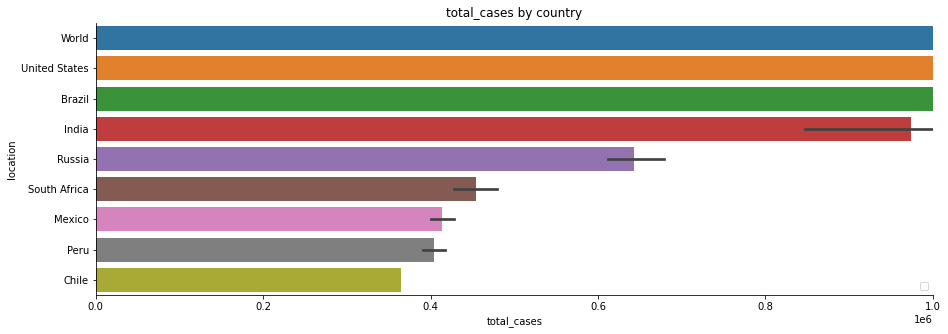

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


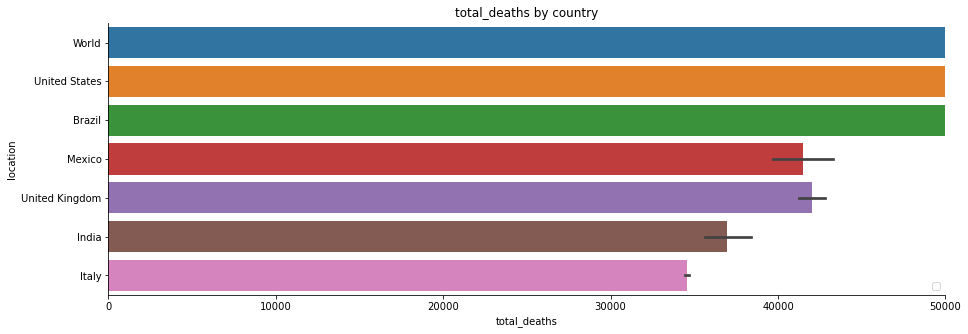

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


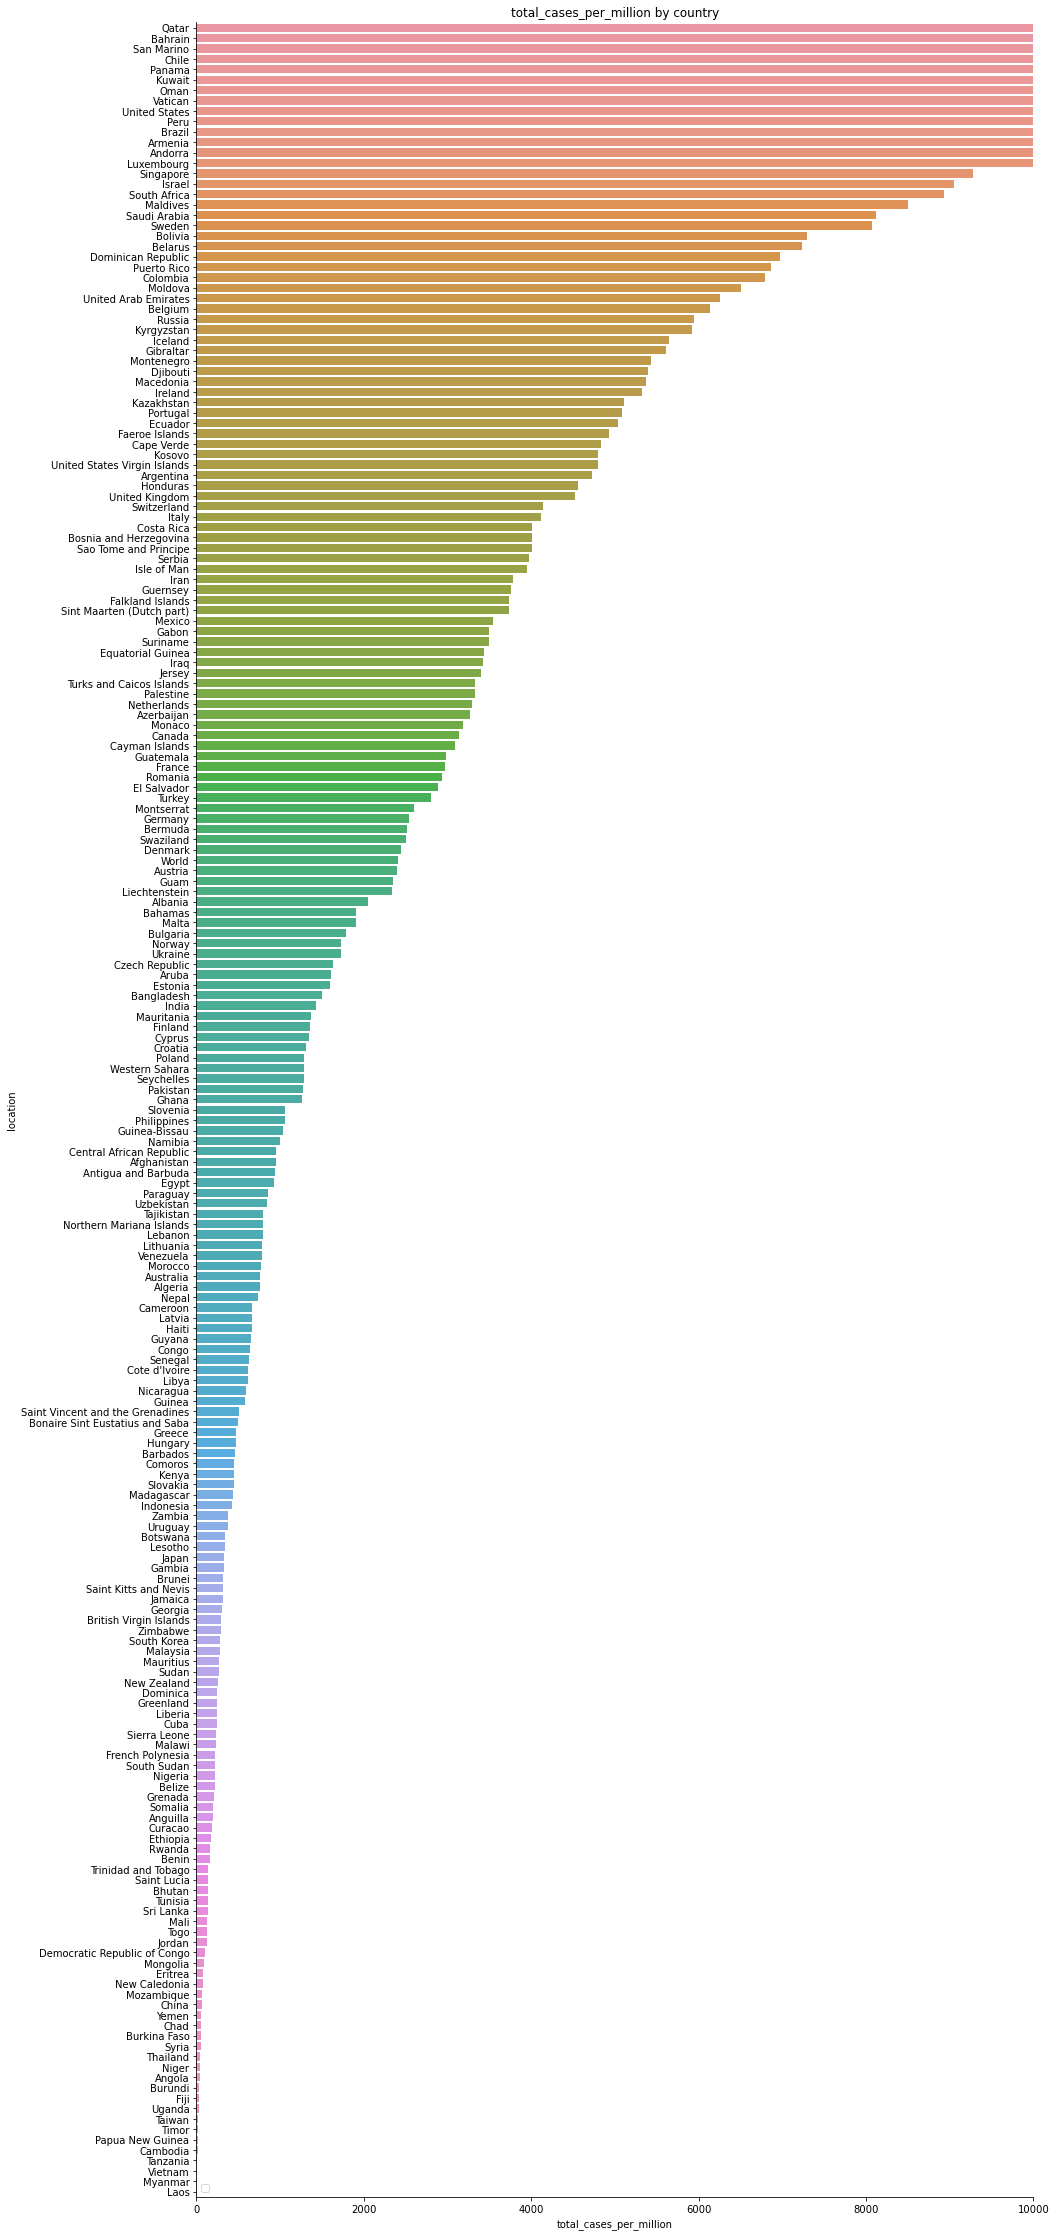

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


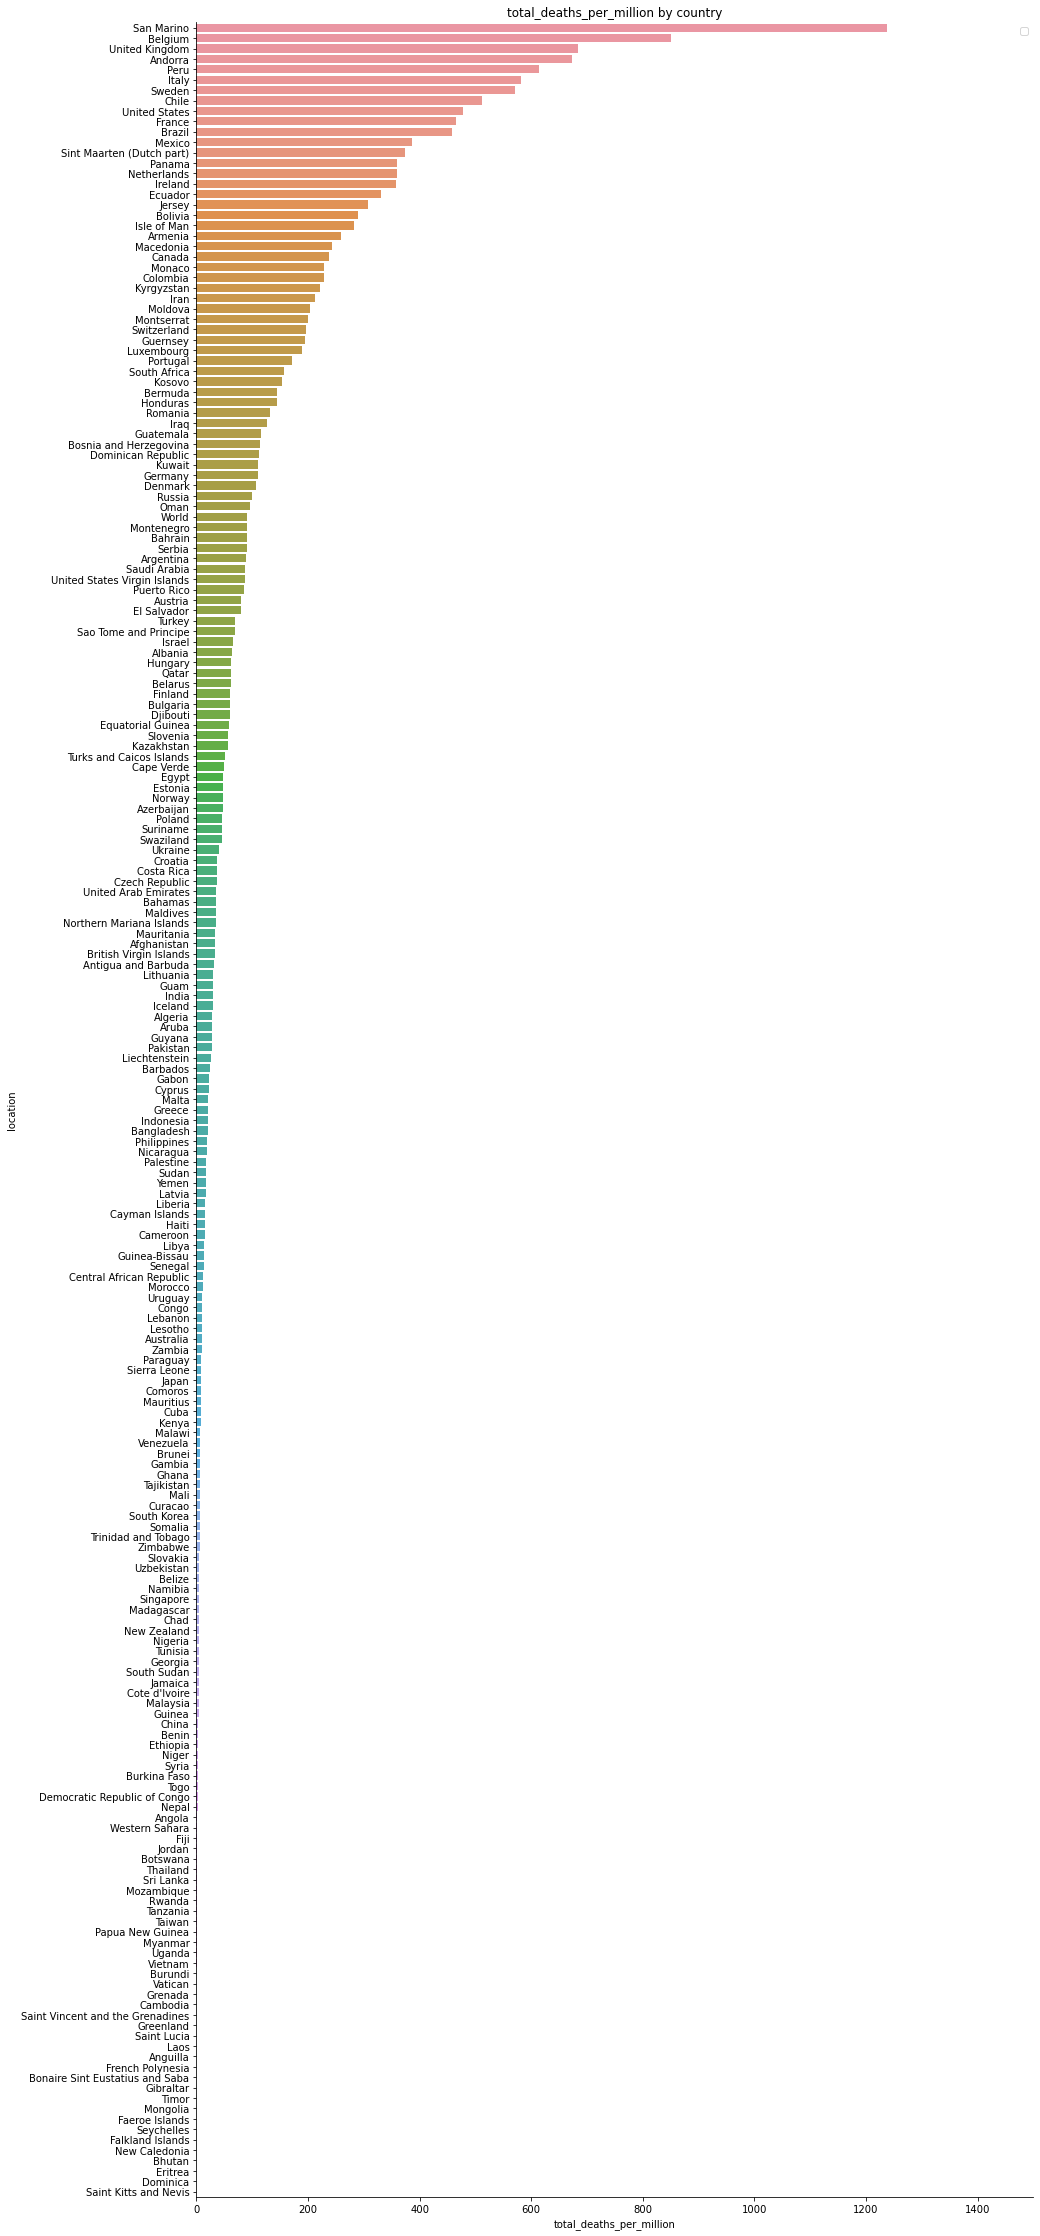

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

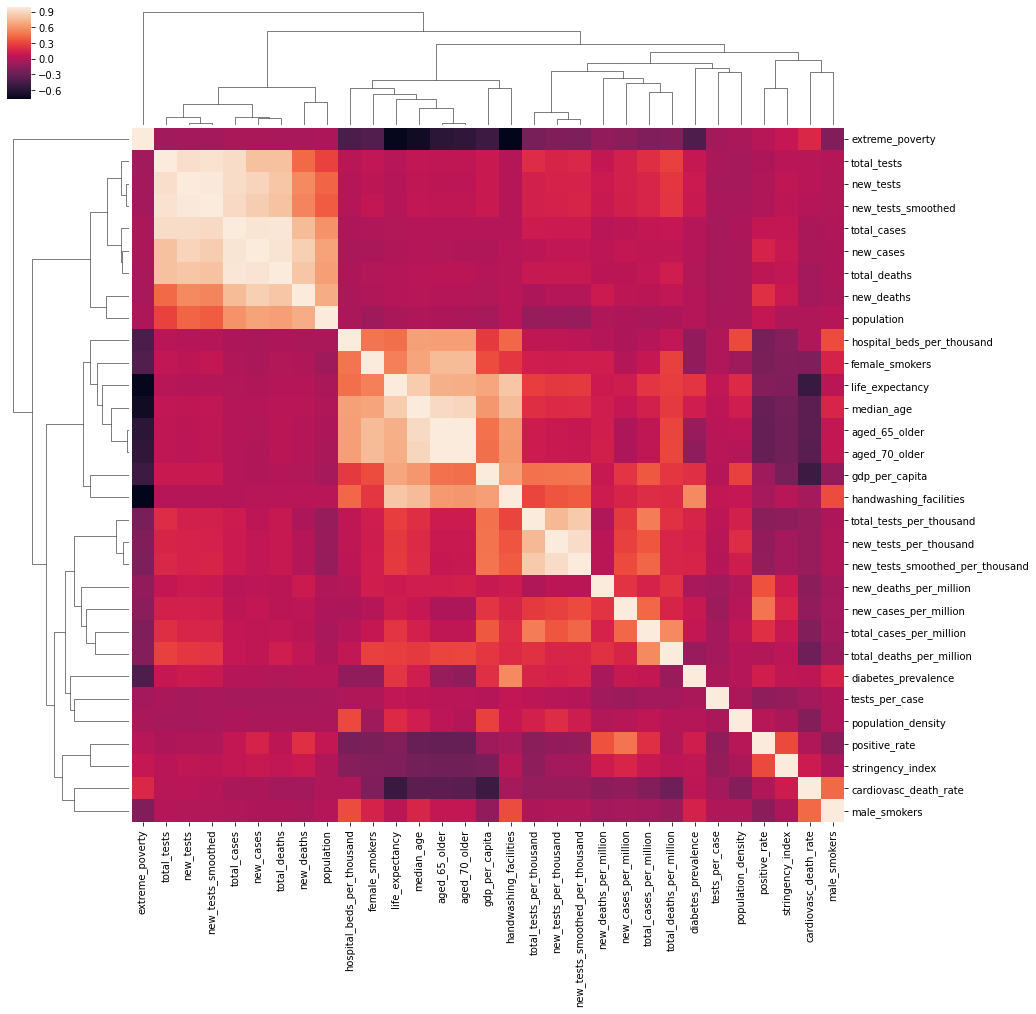

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996380538471709 (+/- 0.0002829516200960359)
Coef :  [1.04636070e+00 8.76121503e-05 9.31775815e-05]
3 Last_days :  [[18270005 18523023 18793522]]
Today :  18793522
Prediction + :  383769
Tomorow :  19177291
                                     
--------- Total Death -----------------
                                     
R^2: 0.9989960439874634 (+/- 0.0006694915931343448)
Coef :  [-0.22441991  0.59526256  0.63800664]
3 Last_days :  [[693736 700547 707715]]
Today :  707715
Prediction + :  6888
Tomorow :  714603
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9907870583859841 (+/- 0.003464944749071329)
Coef :  [-0.69601813  0.75420483  0.94198727]
3 Last_days :  [[191295 192334 194029]]
Today :  194029
Prediction + :  975
Tomorow :  195004
                                     
--------- Total Death -----------------
                                     
R^2: 0.46575566488837783 (+/- 0.7259881446476407)
Coef :  [-0.75801713  0.78770568  0.96952452]
3 Last_days :  [[30294 30296 30305]]
Today :  30305
Prediction + :  27
Tomorow :  30332
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5060140006717964 (+/- 0.4234594141330016)
Coef :  [-0.31864159 -0.03069422  1.34359848]
3 Last_days :  [[88099 88206 88328]]
Today :  88328
Prediction + :  98
Tomorow :  88426
                                     
--------- Total Death -----------------
                                     
R^2: -1512.7247720138228 (+/- 2139.4715788274398)
Coef :  [-0.07621817  0.01239471  1.05600326]
3 Last_days :  [[4672 4676 4677]]
Today :  4677
Prediction + :  8
Tomorow :  4685
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9271820715566713 (+/- 0.10047790294932707)
Coef :  [-0.84512513  0.90856822  0.93578505]
3 Last_days :  [[248229 248419 248803]]
Today :  248803
Prediction + :  298
Tomorow :  249101
                                     
--------- Total Death -----------------
                                     
R^2: 0.9290706222758051 (+/- 0.08642035553742845)
Coef :  [-0.84239915  0.9068402   0.93484176]
3 Last_days :  [[35166 35171 35181]]
Today :  35181
Prediction + :  27
Tomorow :  35208
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6167427196101465 (+/- 0.517752150612846)
Coef :  [-0.78116993  0.81266212  0.96848579]
3 Last_days :  [[297054 302814 305767]]
Today :  305767
Prediction + :  4788
Tomorow :  310555
                                     
--------- Total Death -----------------
                                     
R^2: 0.3237605637454981 (+/- 0.7514999019853407)
Coef :  [-0.70898011  0.59124593  1.11677238]
3 Last_days :  [[28472 28498 28499]]
Today :  28499
Prediction + :  28
Tomorow :  28527
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9918334082923472 (+/- 0.011037659475965831)
Coef :  [0.02170562 0.49464061 0.50530405]
3 Last_days :  [[4713562 4771087 4823891]]
Today :  4823891
Prediction + :  83962
Tomorow :  4907853
                                     
--------- Total Death -----------------
                                     
R^2: 0.5252114421618508 (+/- 0.6668082990168966)
Coef :  [-0.69063469  0.79458733  0.89795252]
3 Last_days :  [[155403 156806 158256]]
Today :  158256
Prediction + :  1323
Tomorow :  159579
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9948524227501654 (+/- 0.005844694708486739)
Coef :  [-0.79772321  0.8844834   0.91334838]
3 Last_days :  [[305623 306293 307184]]
Today :  307184
Prediction + :  890
Tomorow :  308074
                                     
--------- Total Death -----------------
                                     
R^2: 0.502443291195194 (+/- 0.6955538388215745)
Coef :  [-0.76745156  0.831381    0.9360746 ]
3 Last_days :  [[46210 46299 46364]]
Today :  46364
Prediction + :  128
Tomorow :  46492
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9960228713533468 (+/- 0.0032754558128003384)
Coef :  [-0.8240783   0.8719572   0.95159525]
3 Last_days :  [[211281 212022 213067]]
Today :  213067
Prediction + :  729
Tomorow :  213796
                                     
--------- Total Death -----------------
                                     
R^2: 0.4929928197430555 (+/- 0.7062152691558934)
Coef :  [-0.80243284  0.84391667  0.95802722]
3 Last_days :  [[9156 9168 9175]]
Today :  9175
Prediction + :  17
Tomorow :  9192
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8096991057340802 (+/- 0.2688761638595143)
Coef :  [0.07266862 0.4713926  0.46941064]
3 Last_days :  [[312035 314786 317483]]
Today :  317483
Prediction + :  3614
Tomorow :  321097
                                     
--------- Total Death -----------------
                                     
R^2: 0.9725342386891082 (+/- 0.03857731569754694)
Coef :  [-0.20992937  0.61183549  0.61108447]
3 Last_days :  [[17405 17617 17802]]
Today :  17802
Prediction + :  229
Tomorow :  18031
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987495286795536 (+/- 0.001465558300346626)
Coef :  [-0.77945141  0.86720826  0.90937682]
3 Last_days :  [[233851 234934 236112]]
Today :  236112
Prediction + :  980
Tomorow :  237092
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995515040546135 (+/- 0.0003101122164832565)
Coef :  [-0.8362205   0.90716234  0.92614084]
3 Last_days :  [[5747 5765 5784]]
Today :  5784
Prediction + :  16
Tomorow :  5800
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4934182500306166 (+/- 0.7132793552963842)
Coef :  [-0.26183713  0.50223394  0.7783274 ]
3 Last_days :  [[2750318 2801921 2859073]]
Today :  2859073
Prediction + :  56706
Tomorow :  2915779
                                     
--------- Total Death -----------------
                                     
R^2: 0.5367159772229072 (+/- 0.6536869202043202)
Coef :  [-0.30679377  0.59187912  0.72804957]
3 Last_days :  [[94665 95819 97256]]
Today :  97256
Prediction + :  1378
Tomorow :  98634
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(18793522, 707715, 19177291, 714603),
 (194029, 30305, 195004, 30332),
 (248803, 35181, 249101, 35208),
 (305767, 28499, 310555, 28527),
 (4823891, 158256, 4907853, 159579),
 (88328, 4677, 88426, 4685),
 (307184, 46364, 308074, 46492),
 (213067, 9175, 213796, 9192),
 (317483, 17802, 321097, 18031),
 (236112, 5784, 237092, 5800),
 (2859073, 97256, 2915779, 98634)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-06,France,195004.0,0.0,30332.0,0.0,0.0,0.0
0,2020-08-06,China,88426.0,0.0,4685.0,0.0,0.0,0.0
0,2020-08-06,Italy,249101.0,0.0,35208.0,0.0,0.0,0.0
0,2020-08-06,Spain,310555.0,0.0,28527.0,0.0,0.0,0.0
0,2020-08-06,United States,4907853.0,0.0,159579.0,0.0,0.0,0.0
0,2020-08-06,World,19177291.0,0.0,714603.0,0.0,0.0,0.0
0,2020-08-06,United Kingdom,308074.0,0.0,46492.0,0.0,0.0,0.0
0,2020-08-06,Germany,213796.0,0.0,9192.0,0.0,0.0,0.0
0,2020-08-06,Iran,321097.0,0.0,18031.0,0.0,0.0,0.0
0,2020-08-06,Turkey,237092.0,0.0,5800.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")